# Exercício programa 3 de MAP3121
## Esse notebook
O objetivo desse notebook é facilitar a correção do exercício programa, deixando as células melhor explicadas e plotando gráficos em cada validação. Daqui também será retirado o material gráfico que vai compor o relatório.
## Autores
Pedro Pimentel Fuoco 11804313 \\
Mateus Bonelli Salomão 11914789 \\

## Importando bibliotecas e arrumando os parâmetros dos graficos

In [1]:
import numpy as np
import math


In [2]:
import matplotlib.pyplot as plt
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

## Funções do EP1 que serão utilizadas

In [3]:
def LU_decomp_tridiag(a,b,c): #Essa funcao recebe uma matriz tridiagonal em sua entrada, nas variaveis a,b e c, e retorna u e l, coeficientes das matrizes de decomposicao LU
    n = len(b[0])
    u = np.zeros((1,n))
    l = np.zeros((1,n))
    # Seguimos o algoritmo proposto no enunciado do EP1
    u[0][0] = b[0][0]
    l[0][0] = 0
    for i in range(1,n):
        l[0][i] = a[0][i]/u[0][i-1]
        u[0][i] = b[0][i]-l[0][i]*c[0][i-1]
    return u, l

def resolve_sistema_nao_ciclico(u,l,c,d): #Resolve para uma matriz  tridiagonal nao ciclica decomposta em LU. as entradas são u,l,c e d. devolve o vetor x, resolucao do sistema linear
    n = len(u[0])
    y = np.zeros((1,n))
    x = np.zeros((1,n))
    y[0][0]=d[0][0]
    for i in range(1,n):
        y[0][i] = d[0][i]-l[0][i]*y[0][i-1]
    x[0][n-1] = y[0][n-1]/u[0][n-1]
    for i in range(n-2,-1,-1):
        x[0][i]=(y[0][i]-c[0][i]*x[0][i+1])/u[0][i]
    return x

## Funções do EP2 que serão utilizadas

In [4]:
def integra(a,b,f,x,w):
    assert len(x) == len(w) 
    #assert type(a) == float and type(b) == float
    I = 0
    if a == -1 and b == 1:                             #acha integral para o caso [a,b]= [1,1]
        for i in range(len(x)):
            I += w[i]*avalia_funcao(f,(x[i]))
        return I
    for i in range(len(x)):
        I += w[i]*avalia_funcao(f,((b-a)*x[i]+(b+a))/2)            #para um intervalo generico faz a mudança y=(2x-a-b)/(b-a) calcula a integral com y em [1,1]
    I *= (b-a)/2
    return I



def avalia_funcao(f, y):    #f sera passada como (ks, ka, d, L)
    if type(f) != str:
      return f(y)
    x = y
    return eval(f)

## Funções que montam o sistema tridigagonal não ciclico e obtém os valores dos $\alpha$

In [5]:
def calcula_as(n, h, k, x, w):                #funcao que calcula a diagonal inferior
    a = []
    a.append([0])
    for i in range(1,n):
        a_i = (-1/(h**2))*integra(i*h, ((i+1)*h), k, x, w) 
        a.append([a_i])
    return np.array(a).T


def calcula_bs(n, h, k, x, w):                #calcula diagonal principal do sistema
    b = []
    for i in range(1,n+1):
        b_i = (1/(h**2))*((integra((i-1)*h, i*h, k, x, w))+integra(i*h, (i+1)*h, k, x, w))
        b.append([b_i])
        #b.append(b_i)
    return np.array(b).T
    #return np.array(b)


def calcula_cs(n, h, k,x, w):                #funcao que calcula a diagonal superiopr
    c = []
    for i in range(1,n):
        c_i = (-1/(h**2))*integra(i*h, ((i+1)*h), k, x, w)
        c.append([c_i])
    c.append([0])
    #return np.array(c)
    return np.array(c).T


def calcula_ds(n, h, f, x, w):              #calcula lado direito do sistema
    d = []
    for i in range(1, n+1):
        d_i = (1/h)*(integra((i-1)*h, i*h, '(' +f + ')'+ '*(x-' + str((i-1)*h) +')', x, w) + integra(i*h, (i+1)*h, '('+ f +')'+'*(' +str((i+1)*h) +'-x)', x,w))      # construo a funcao de dentro concatenando os string e depois avalio com o avalia_vunao
        d.append([d_i])
        #d.append(d_i)
    return np.array(d).T
    #return np.array(d)


def calcula_alphas(n, h,f, k, x, w):       #retorna os alphas que solucionam o sistema tridiagonal proposto
    a= calcula_as(n, h, k, x, w)
    b= calcula_bs(n, h, k, x, w)
    c= calcula_cs(n, h, k, x, w)
    d = calcula_ds(n, h, f, x, w)
    u, l = LU_decomp_tridiag(a,b,c)
    return resolve_sistema_nao_ciclico(u, l, c, d)

## Funções que montam a aproximação por splines lineares

In [6]:
def u_barra(L, alphas, x):
    n = len(alphas[0])
    h = L/(n+1)
    x_i = np.resize(np.arange(0,n+2)*h,(1,n+2))
    value = 0
    for i in range(1, len(x_i[0])-1):
        phi = 0
        if x >= x_i[0][i-1] and x <= x_i[0][i]:
            phi = (1/h)*(x-x_i[0][i-1])
        elif  x > x_i[0][i] and x < x_i[0][i+1]:
            phi = (1/h)*(x_i[0][i+1]-x)
        value += alphas[0][i-1]*phi
    return value

def u_barra_n_homog(alphas, a, b, L, x):
    v = u_barra(L, alphas, x)
    u_b  = str(v) + '+' + str(a) + '+' + '('+'(' + str(b) + '-' + str(a) + ')' + '/' +str(L)+')' + '*' + 'x'
    return avalia_funcao(u_b, x)

def calcular_aproximacao(u,a, b,L, alphas, n):
  vetor_u = []
  vetor_u_barra = []
  erros = []
  vetor_i = np.arange(n*L)/n
  for i in range(int(n*L)):
    vetor_u_barra.append(u_barra_n_homog(alphas,a, b,L, vetor_i[i]))
    if u != '':
      vetor_u.append(avalia_funcao(u,vetor_i[i]))
  return vetor_u, vetor_u_barra, vetor_i

def calcula_erros(vetor_u, vetor_u_barra, L, n):
    erros = []
    for i in range(int(n*L)):
        erros.append(abs(vetor_u[i] - vetor_u_barra[i]))
    return erros

## Teste proposto no item 4.2 do enunciado
Nesse teste, as condições de contorno são homogêneas, L é dado como 1, o valor de k é constante e igual a 1 e uma função com valor exato é dada para que os resultados possam ser comparados

In [7]:
print("Teste proposto no item 4.2 do enunciado")
x1 = np.array([-math.sqrt(1/3), math.sqrt(1/3)])          #nos e pesos para a formula de Gauss com 2 pontos
w1 = np.array([1, 1])
n = int(input('Digite n: '))
h = 1/(n+1)
k = '1'
f = '12*x*(1-x)-2'
u = '(x**2)*((1-x)**2)'   
# Intervalo [0,1]
L = 1
# Condições de contorno
a = 0
b = 0 

alphas = calcula_alphas(n,h,f,k,x1, w1)
vetor_u, vetor_u_barra, vetor_i = calcular_aproximacao(u, a, b, L, alphas,1000)
erros = calcula_erros(vetor_u,vetor_u_barra,L,1000)

Teste proposto no item 4.2 do enunciado
Digite n: 15


### Plotando $u(x)$ e $\overline{u}_n(x)$

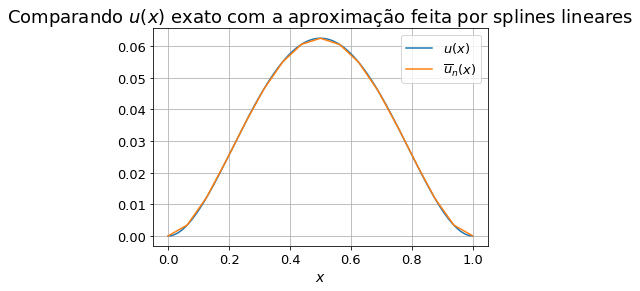

In [8]:
plt.plot(vetor_i, vetor_u)
plt.plot(vetor_i,vetor_u_barra)
plt.xlabel('$x$')
plt.title('Comparando $u(x)$ exato com a aproximação feita por splines lineares') 
plt.legend(title_fontsize = 8, labels = ['$u(x)$','$\overline{u}_n(x)$'])
plt.grid()
plt.show()

### Verificando a convergência do método utilizado

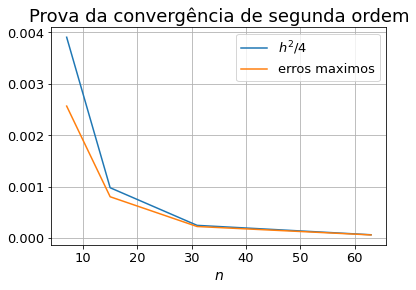

In [9]:
n_testes = [7, 15, 31, 63]
h_testes = []
erros_maximos = []
for n in n_testes:
  h = 1/(n+1)
  h_testes.append(h)
  alphas = calcula_alphas(n, h,f, k, x1, w1)
  vetor_u, vetor_u_barra, vetor_i = calcular_aproximacao(u, a, b, L, alphas,1000)
  erros = calcula_erros(vetor_u,vetor_u_barra,L,1000)
  erros_maximos.append(np.amax(erros))
plt.plot(n_testes, np.multiply(h_testes,h_testes)/4)
plt.plot(n_testes, erros_maximos)
plt.xlabel('$n$')
plt.title('Prova da convergência de segunda ordem') 
plt.legend(title_fontsize = 8, labels = ['$h^2/4$','erros maximos'])
plt.grid()
plt.show()

## Teste adicional sugerido como complemento ao item 4.2 do enunciado do exercício programa
Nesse teste, as condições de contorno são homogêneas, L é dado como 1 e uma função com valor exato é dada para que os resultados possam ser comparados. Porém o valor de k passa a ser uma função de x, no caso $k(x) = e^x$

In [10]:
print("Teste adicional sugerido como complemento ao item 4.2 do enunciado do exercício programa")
x1 = np.array([-math.sqrt(1/3), math.sqrt(1/3)])          #nos e pesos para a formula de Gauss com 2 pontos
w1 = np.array([1, 1])
n = int(input('Digite n: '))
h = 1/(n+1)
k = '(math.e)**x'
f = '1 + (math.e)**(x)'
u = '(x-1)*(-1+(math.e)**(-x))'    
# Intervalo [0,1]
L = 1
# Condições de contorno
a = 0
b = 0 

alphas = calcula_alphas(n, h,f, k, x1, w1)
vetor_u, vetor_u_barra, vetor_i = calcular_aproximacao(u, a, b, L, alphas,1000)
erros = calcula_erros(vetor_u,vetor_u_barra,L,1000)

Teste adicional sugerido como complemento ao item 4.2 do enunciado do exercício programa
Digite n: 15


### Plotando $u(x)$ e $\overline{u}_n(x)$

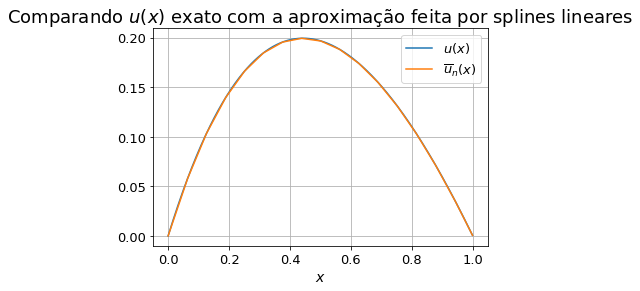

In [11]:
plt.plot(vetor_i, vetor_u)
plt.plot(vetor_i,vetor_u_barra)
plt.xlabel('$x$')
plt.title('Comparando $u(x)$ exato com a aproximação feita por splines lineares') 
plt.legend(title_fontsize = 8, labels = ['$u(x)$','$\overline{u}_n(x)$'])
plt.grid()
plt.show()

### Verificando a convergência do método utilizado

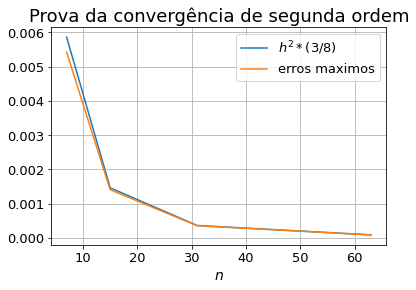

In [12]:
n_testes = [7, 15, 31, 63]
h_testes = []
erros_maximos = []
for n in n_testes:
  h = 1/(n+1)
  h_testes.append(h)
  alphas = calcula_alphas(n, h,f, k, x1, w1)
  vetor_u, vetor_u_barra, vetor_i = calcular_aproximacao(u, a, b, L, alphas,1000)
  erros = calcula_erros(vetor_u,vetor_u_barra,L,1000)
  erros_maximos.append(np.amax(erros))
plt.plot(n_testes, np.multiply(h_testes,h_testes)*(3/8))
plt.plot(n_testes, erros_maximos)
plt.xlabel('$n$')
plt.title('Prova da convergência de segunda ordem') 
plt.legend(title_fontsize = 8, labels = ['$h^2 * (3/8)$','erros maximos'])
plt.grid()
plt.show()

## Solução para k constante e condições de contorno não homogêneas, intervalo [0,L]
Para testar a variação das condições de contorno e do intervalo, esse teste é executado e uma comparação é feita com o valor esperado

In [13]:
print("Solução para k constante e condições de contorno não homogêneas, intervalo [0,L]")
x1 = np.array([-math.sqrt(1/3), math.sqrt(1/3)])          #nos e pesos para a formula de Gauss com 2 pontos
w1 = np.array([1, 1])
n = int(input('Digite n: '))
k = '1'
f = '-2'
u = '(x**2+1)'
# intervalo [0,L]
L = float(input('Digite L: '))
h = L/(n+1)
# Condições de contorno
a = avalia_funcao(u, 0)
b = avalia_funcao(u, L) 


alphas = calcula_alphas(n, h,f, k, x1, w1)
vetor_u, vetor_u_barra, vetor_i = calcular_aproximacao(u, a, b, L, alphas,1000)
erros = calcula_erros(vetor_u,vetor_u_barra,L,1000)

Solução para k constante e condições de contorno não homogêneas, intervalo [0,L]
Digite n: 15
Digite L: 15


### Plotando $u(x)$ e $\overline{u}_n(x)$

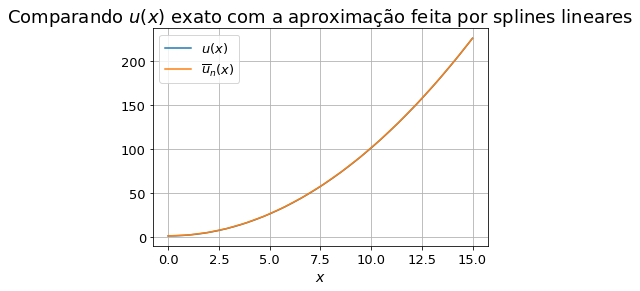

In [14]:
plt.plot(vetor_i, vetor_u)
plt.plot(vetor_i,vetor_u_barra)
plt.xlabel('$x$')
plt.title('Comparando $u(x)$ exato com a aproximação feita por splines lineares') 
plt.legend(title_fontsize = 8, labels = ['$u(x)$','$\overline{u}_n(x)$'])
plt.grid()
plt.show()

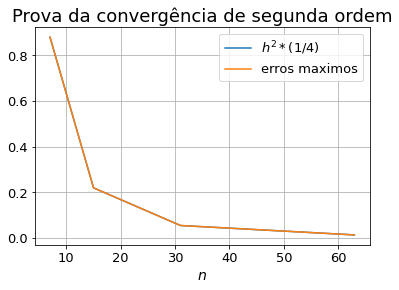

In [15]:
n_testes = [7, 15, 31, 63]
h_testes = []
erros_maximos = []
for n in n_testes:
  h = L/(n+1)
  h_testes.append(h)
  alphas = calcula_alphas(n, h,f, k, x1, w1)
  vetor_u, vetor_u_barra, vetor_i = calcular_aproximacao(u, a, b, L, alphas,1000)
  erros = calcula_erros(vetor_u,vetor_u_barra,L,1000)
  erros_maximos.append(np.amax(erros))
plt.plot(n_testes, np.multiply(h_testes,h_testes)*(1/4))
plt.plot(n_testes, erros_maximos)
plt.xlabel('$n$')
plt.title('Prova da convergência de segunda ordem') 
plt.legend(title_fontsize = 8, labels = ['$h^2 * (1/4)$','erros maximos'])
plt.grid()
plt.show()

## Problema físico: Equilíbrio com forçantes de calor
Considerando ainda um k de material único, esses testes são feito para mostrar a solução gerada pelo grupo atuando conforme o equilíbrio com forçantes de calor, conforme proposto no item 4.3 do enunciado do exercício programa.

In [16]:
print("Daqui para frente trataremos do problema físico, com forçantes de calor")

Daqui para frente trataremos do problema físico, com forçantes de calor


### Caso simplificado: Calor gerado e retirado constantes e uniformes

In [17]:
print("Caso simplificado: Calor gerado e retirado constantes e uniformes")
x1 = np.array([-math.sqrt(1/3), math.sqrt(1/3)])          #nos e pesos para a formula de Gauss com 2 pontos
w1 = np.array([1, 1])
n = int(input('Digite n: '))
k = '0.148'
# intervalo [0,L]
L = 20
h = L/(n+1)
# Forçantes de calor
Q_0_mais = 95/(20*20*2)
Q_0_menos = Q_0_mais * 0.5
f = str(Q_0_mais)+ '-' + str(Q_0_menos)

# Condições de contorno (temperatuda nas extremidades)
a = 293
b = 293    


alphas = calcula_alphas(n, h,f, k, x1, w1)
_ , vetor_u_barra, vetor_i = calcular_aproximacao(u, a, b, L, alphas,1000)


Caso simplificado: Calor gerado e retirado constantes e uniformes
Digite n: 61


#### Plotando a variação de temperatura aproximada no chip $\overline{T}_n(x)$

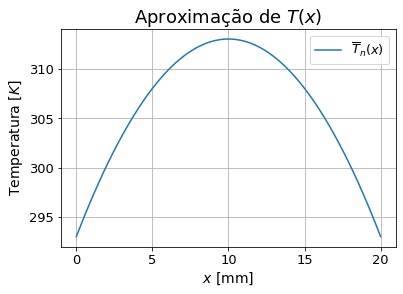

In [18]:
plt.plot(vetor_i,vetor_u_barra)
plt.xlabel('$x$ [mm]')
plt.ylabel('Temperatura [$K$]')
plt.title('Aproximação de $T(x)$') 
plt.legend(title_fontsize = 8, labels = ['$\overline{T}_n(x)$'])
plt.grid()
plt.show()

### Primeiro caso de maior complexidade: 
Calor gerado ditado pela gaussiana indicada no enunciado e calor retirado uniforme (constante)

In [19]:
print("Primeiro caso de maior complexidade: Calor ditado pela gaussiana e resfriamento constante e uniforme")
x1 = np.array([-math.sqrt(1/3), math.sqrt(1/3)])          #nos e pesos para a formula de Gauss com 2 pontos
w1 = np.array([1, 1])
n = int(input('Digite n: '))
k = '0.148'
# intervalo [0,L]
L = 20
h = L/(n+1)
# Forçantes de calor
Q_0_mais = 95/(20*20*2)
Q_0_menos = Q_0_mais * 0.5
sigma = 7
f = str(Q_0_mais)+ '*('+ '(math.e)**'+'(-'+ '(' + '(x-'+str(L/2) +')'+'**2' +')' + '/' + str(sigma**2) +')' + ')'  + '-' + str(Q_0_menos)
u = ''
# Condições de contorno (temperatuda nas extremidades)
a = 293
b = 293    


alphas = calcula_alphas(n, h,f, k, x1, w1)
_ , vetor_u_barra, vetor_i = calcular_aproximacao(u, a, b, L, alphas,1000)

Primeiro caso de maior complexidade: Calor ditado pela gaussiana e resfriamento constante e uniforme
Digite n: 61


#### Plotando a variação de temperatura aproximada no chip $\overline{T}_n(x)$

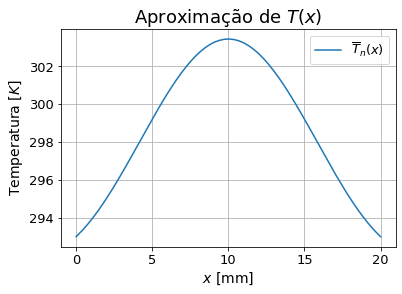

In [20]:
plt.plot(vetor_i,vetor_u_barra)
plt.xlabel('$x$ [mm]')
plt.ylabel('Temperatura [$K$]')
plt.title('Aproximação de $T(x)$') 
plt.legend(title_fontsize = 8, labels = ['$\overline{T}_n(x)$'])
plt.grid()
plt.show()

### Segundo caso de maior complexidade: 
Calor gerado e retirado ditados pela gaussiana indicada no enunciado

In [21]:
print("Segundo caso de maior complexidade: Calor gerado e resfriado seguindo suas respectivas gaussianas")
x1 = np.array([-math.sqrt(1/3), math.sqrt(1/3)])          #nos e pesos para a formula de Gauss com 2 pontos
w1 = np.array([1, 1])
n = int(input('Digite n: '))
k = '0.148'
# intervalo [0,L]
L = 20
h = L/(n+1)
# Forçantes de calor
Q_0_mais = 95/(20*20*2)
Q_0_menos = Q_0_mais * 0.5
sigma = 7
theta = 14
f = str(Q_0_mais)+ '*('+ '(math.e)**'+'(-'+ '(' + '(x-'+str(L/2) +')'+'**2' +')' + '/' + str(sigma**2) +')' + ')'  + '-' + str(Q_0_menos) + '*(math.e**((-(x)**2)/(' + str(theta**2) + ')) + math.e**(-((x-' + str(L) + ')**2)/('+ str(theta**2) + ')))'
u = ''
# Condições de contorno (temperatuda nas extremidades)
a = 293
b = 293    


alphas = calcula_alphas(n, h,f, k, x1, w1)
_ , vetor_u_barra, vetor_i = calcular_aproximacao(u, a, b, L, alphas,1000)

Segundo caso de maior complexidade: Calor gerado e resfriado seguindo suas respectivas gaussianas
Digite n: 61


#### Plotando a variação de temperatura aproximada no chip $\overline{T}_n(x)$

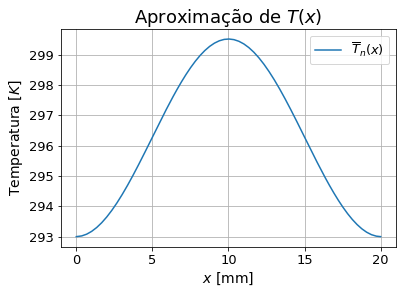

In [22]:
plt.plot(vetor_i,vetor_u_barra)
plt.xlabel('$x$ [mm]')
plt.ylabel('Temperatura [$K$]')
plt.title('Aproximação de $T(x)$') 
plt.legend(title_fontsize = 8, labels = ['$\overline{T}_n(x)$'])
plt.grid()
plt.show()

## Equilíbrio com variação de material
Considerando agora um k com variação de material, esse teste é feito para mostrar a solução gerada pelo grupo atuando conforme o item 4.4 do enunciado do exercício programa 

In [23]:
print("Caso com variação de material: chip de silicio e aluminio!")
x1 = np.array([-math.sqrt(1/3), math.sqrt(1/3)])          #nos e pesos para a formula de Gauss com 2 pontos
w1 = np.array([1, 1])
n = int(input('Digite n: '))
# intervalo [0,L]
L = 20
h = L/(n+1)
# Condutividades dos materiais  
ks = 0.148
ka = 0.204
d = 6.5
k = lambda x: ks if ((L/2-d)<x and x<(L/2+d)) else ka
# Forçantes de calor
Q_0_mais = 95/(20*20*2)
Q_0_menos = Q_0_mais * 0.5
sigma = 7
theta = 14
f = str(Q_0_mais)+ '*('+ '(math.e)**'+'(-'+ '(' + '(x-'+str(L/2) +')'+'**2' +')' + '/' + str(sigma**2) +')' + ')' + '-' + str(Q_0_menos) + '*(math.e**((-(x)**2)/(' + str(theta**2) + ')) + math.e**(-((x-' + str(L) + ')**2)/('+ str(theta**2) + ')))'
u = ''
# Condições de contorno (temperatuda nas extremidades)
a = 293
b = 293

alphas = calcula_alphas(n, h,f, k, x1, w1)
_ , vetor_u_barra, vetor_i = calcular_aproximacao(u, a, b, L, alphas,1000)


Caso com variação de material: chip de silicio e aluminio!
Digite n: 61


### Plotando a variação de temperatura aproximada no chip $\overline{T}_n(x)$

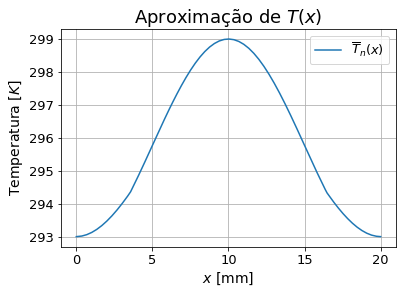

In [24]:
plt.plot(vetor_i,vetor_u_barra)
plt.xlabel('$x$ [mm]')
plt.ylabel('Temperatura [$K$]')
plt.title('Aproximação de $T(x)$') 
plt.legend(title_fontsize = 8, labels = ['$\overline{T}_n(x)$'])
plt.grid()
plt.show()